# Feature engineering and dataset transformations

### Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import TimeSeriesSplit

In [2]:
%run functions_EDA.py

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
d = pd.read_csv("data/daily_sales_report.csv")
school_h_be = pd.read_csv("data/hol_school_b.csv")
school_h_hh = pd.read_csv("data/hol_school_h.csv")

## Feature engineering

The features in the dataset need to be transformed in some ways to make the analysis more coherent and the sales forecasting more precise. 

For example, the dataset contains information on total sales of several hundred different products. These products were clustered into several different categories to make the analysis easier. Additional features, such as the occurence of public or school holidays, were added as well

#### Converting *date* to datetime 

The *date* variable was converted to a pandas datetime format.

In [5]:
d['date'] = pd.to_datetime(d['date'])

#### Categorizing

There are over 300 different item names in the dataset. This function clusters these items into 8 separate categories.

In [6]:
d['item_category'] = d['item_name'].apply(categorize_item)

#### Calculating total amount

Some of the sold items were boxes with mulitple individual donuts inside. The function below converts those items into a total amount. For example, if a box contained 4 donuts, then the amount sold isn't 1 box anymore, but 4 donuts.

In [7]:
d['total_amount'] = d.apply(calculate_total_amount, axis=1)

#### Dropping duplicates

The dataset contains older and newer ways of accounting for sales. Before July 12 2021, donut sales were not split into individual items, but were instead recorded as the total number of donuts sold on a day. Between that date and until May 2022, the total amount was recorded additionally to the individual sales of different donut types. In order to avoid double-counting, the category *donuts sold (old)* was removed after July 12, 2021.

In [8]:
d = drop_duplicates(d)

#### Remove stores in Eppendorf, Schöneberg, Hauptbahnhof from dataset 

Some stores had insufficient data or were too new to meaningfully include in the forecasting model. They were removed.

In [9]:
d = d[(d["date"] <= pd.to_datetime("2024-05-31")) &
           (-d["store_name"].isin(["Eppendorf","Schöneberg","Hauptbahnhof", 'Hamburg Hauptbahnhof',"KaDeWe"]))]

In [10]:
d.columns

Index(['date', 'location_id', 'Location_name', 'store_id', 'store_name',
       'type_id', 'type_name', 'item_id', 'item_name', 'amount',
       'item_category', 'total_amount'],
      dtype='object')

#### Daily total 

A new category was added to the *item name* and *item category* columns, namely "daily total". The daily total is the total amount of donuts sold per day and per store. This function entirely removes the "donuts sold (old)" category. 

The reason for calculating the daily total sales is for easier sales forecasting. The function still retains individual donut categories, so predicting sales of these is also possible.

In [11]:
d = daily_total(d)

#### Weather variables

The function adds three new weather variables to the dataset by sending an API request to the open-meteo.com server. 

* Daily Precipitation (hours)
* Daily Temperature (°C)
* Daily Sunshine Duration (seconds)

The sunshine duration was divided by 3600 to obtain daily sunshine duration in hours.

In [12]:
d = weather_data(d)

In [13]:
d["sunshine_duration"] = d["sunshine_duration"]/3600

#### Balancing Item Categories

The category "other" in the *item category* column consists of over 200 different items. Some of these items are, in fact, donuts of some type, while others are other items such as ice cream. 

Below is an overview of how many items are classified as "other".

<Axes: xlabel='Item Category', ylabel='Frequency (%)'>

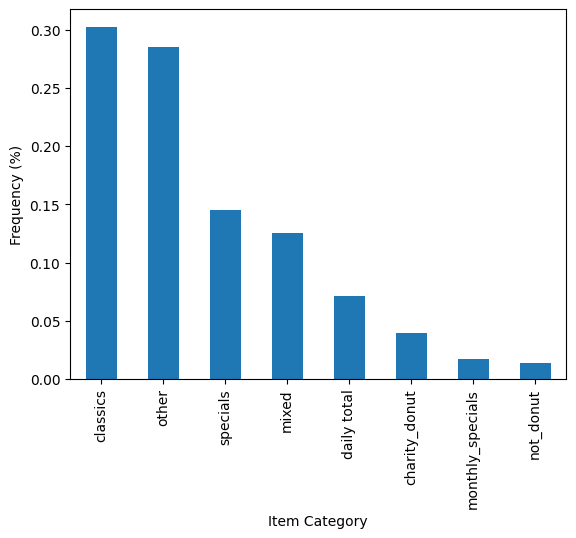

In [14]:
d["item_category"].value_counts(normalize = True).plot(kind = "bar", ylabel = "Frequency (%)", xlabel = "Item Category")

The function below updates and reclassifies the "other" category as a donut type or, if it's not a donut, leaves it in the "other" category.

In [15]:
updated_d = update_item_category(d)

Now the "other" category is only a fraction of the total number of donuts.

<Axes: xlabel='Item Category', ylabel='Frequency (%)'>

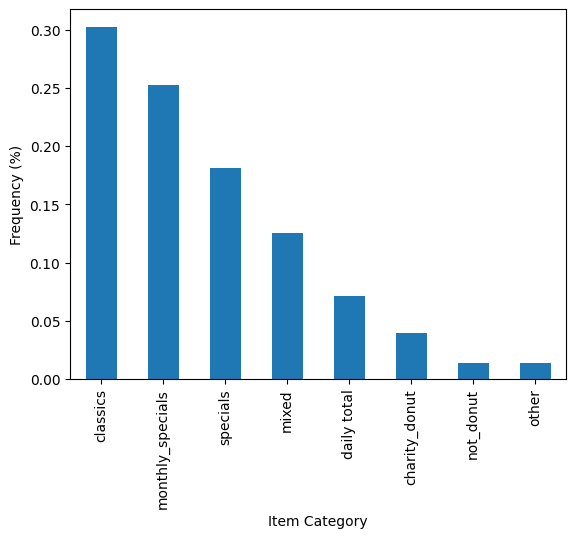

In [16]:
updated_d["item_category"].value_counts(normalize = True).plot(kind = "bar", ylabel = "Frequency (%)", xlabel = "Item Category")

In [17]:
updated_d[updated_d["item_category"] == "other"]["item_name"].value_counts()

item_name
Oatly Softeis             541
Softeis                   441
Softi - Dount             298
Special Softi             278
donuts in boxes (wolt)    276
Softi - Cup               273
Name: count, dtype: int64

Since it doesn't contain any useful information anymore, the "other" category is dropped from the dataset.

In [18]:
updated_d = updated_d[~updated_d["item_category"].isin(["other","not_donut"])].reset_index(drop = True)

In [19]:
updated_d["item_category"].value_counts()

item_category
classics            47364
monthly_specials    39605
specials            28336
mixed               19631
daily total         11171
charity_donut        6190
Name: count, dtype: int64

#### Drop year and month features to avoid duplicates below

The function above created the *year* and *month* features. They are dropped because features related to time are added below.

In [20]:
updated_d = updated_d.drop(["year","month"], axis = 1)

#### Adding holidays

The two functions below add the public and school holiday features. The assumption is that holidays impact the number of sold donuts. 

In [21]:
updated_d = hol_pub(updated_d)

In [22]:
updated_d = hol_school(updated_d, school_h_be, school_h_hh)

#### Adding date info

The function below add the following time variables:

* Weekday (Monday to Sunday)
* Day of the year (1 - 365)
* Month (1 - 12)
* Year
* Week of the year (1 - 52)

In [23]:
updated_d = date_info(updated_d)

#### Creating Special Events dummy variables

Some special events, such as New Year's Eve (NYE) or Valentine's Day, explain much higher sales during certain weeks of the year. This can be explored in the Visualisation notebook.

 Therefore, three new dummy variables were added where 1 marks the following special days:

* NYE
* Valentine's Day
* Halloween

In [24]:
updated_d['nye'] = updated_d['date'].apply(lambda x: 1 if (x.month ==12 and x.day ==31) else 0)
updated_d['valentines_day'] = updated_d['date'].apply(lambda x: 1 if (x.month ==2 and x.day ==14) else 0)
updated_d['halloween'] = updated_d['date'].apply(lambda x: 1 if (x.month == 10 and (x.day ==29 or x.day ==30 or x.day ==31)) else 0)

#### Creating "weekend" dummy variable

A new variable signifying weekend days (Saturday and Sunday) was added. Weekend sales are much higher than during the regular work week. For more, refer to the Visualisation notebook. 

In [25]:
updated_d["weekend"] = updated_d["weekday"].apply(lambda x: 1 if x in [5,6] else 0)

#### Adding "street_market" dummy variable

Some stores are located close to know street markets that take place on certain days of the week. It is expected that donut sales are higher on those days.

In [26]:
updated_d  = dummy_street_market(updated_d)

#### Creating "public_space" dummy variable

Some stores are located close to more touristic areas, while others operate in residential neighbourhoods. It is expected that store locations in touristic areas tend to sell more donuts because there is a more diverse customer base.

In [27]:
updated_d["public_space"] = updated_d["store_name"].apply(lambda x: 1 if x in ["Potsdamer","Altona","KaDeWe","Hamburg Hauptbahnhof","Mitte"] else 0)

#### Creating "box_deal" dummy variable

Donuts can be bought individually or in boxes. By buying boxes, each individual donut costs less than they would if they were purchased individually, so customers might decide to go for a 4 donut box instead of buying 3 donuts separately. The *box deal* may have an effect on the number of donuts sold.

In [28]:
updated_d["box_deal"] = updated_d["type_name"].apply(lambda x: 1 if x in "box" else 0)

### Binning weather variables

The assumption is that weather impacts donut sales, yet gradual increased or decreases, for instance between 15 and 16°C, do not make much of a difference.

The weather variables were therefore binned into different categories to make the effect of weather clearer. How weather affects donut sales can be seen in the Visualisation notebook.

#### Rainfall

In [29]:
updated_d["rainfall_bins"] = pd.cut(updated_d["precipitation_hours"], bins=[updated_d["precipitation_hours"].min() - 1, 4, 8, 12, 16, updated_d["precipitation_hours"].max() + 1], labels = ["0-4 hrs", "4-8 hrs" ,"8-12 hrs", "12-16 hrs", "> 16 hrs"])

#### Temperature

In [30]:
updated_d["temp_bins"] = pd.cut(updated_d["temperature_2m_mean"], bins=[updated_d["temperature_2m_mean"].min() - 1, 0, 10, 15, 20, 25, d["temperature_2m_mean"].max() + 1], labels = ["< 0°C", "0 - 10°C", "10 - 15°C", "15 - 20°C", "20 - 25°C", "> 25°C"])

#### Sunshine

In [31]:
updated_d["sunshine_bins"] = pd.cut(updated_d["sunshine_duration"], bins=[updated_d["sunshine_duration"].min() - 1, 4, 8, 12, d["sunshine_duration"].max() + 1], labels = ["0-4 hrs", "4-8 hrs", "8-12 hrs", "> 12 hrs"])

#### Dropping ID columns

In [32]:
updated_d = updated_d.drop(["location_id","store_id","type_id","item_id"], axis = 1)

#### Creating lagged variables

Lagged variables are essential in modelling sales forecasts. A lagged variable of 1 day means that the previous day's sales can predict today's sales. When other effects, such as holidays or weather, are taken into account as predictors of sales, what usually remains is a very strong correlation between the lagged variable and the sales variable. 

The function below creates lagged variables for the past day, the past two days as well as for the past week.

In [33]:
updated_d  = lag(updated_d)

### Time Series split

The time series split ensures that the data is split into a training and test set. Precisely forecasting sales for more than one week is difficult, which is why the test set is only the last week in the dataset.

In [34]:
updated_d = updated_d.set_index("date")

In [36]:
days = np.sort(updated_d.index.unique())

In [38]:
tscv = TimeSeriesSplit(n_splits=2, test_size = 7)

In [39]:
for train_index, test_index in tscv.split(days):
    train_days, test_days = days[train_index], days[test_index]
    train, test = updated_d.loc[train_days], updated_d.loc[test_days]

In [40]:
updated_d = updated_d.reset_index()

In [41]:
train = train.sort_values("date", ascending = False)
test = test.sort_values("date", ascending = False)

In [42]:
train = train.reset_index()
test = test.reset_index()

#### Timestep for both test and train set

The timestep is a new variable that counts the number of days that passed since the first day of sales. If there is a linear trend, the timestep can partially explain the increase in sales over a multi-year period.

In [43]:
train['days_back'] =(datetime(2024, 5, 24) - train['date']).dt.days
test['days_back'] =(datetime(2024, 5, 31) - test['date']).dt.days

#### Removing lag1, lag2 and lag7 in test dataset

The test dataset must not contain any information about the sales from the previous days except on its first day. Since another function will predict sales and adjust the lagged variables day by day, the lagged variables are drop from the test dataset for now.

In [44]:
test.drop(["lag1","lag2","lag7"], axis = 1, inplace = True)

### Creating .csv files

In [ ]:
updated_d.to_csv("data/cleaned_df.csv", index = False)

train.to_csv("data/train_df.csv", index=False)
test.to_csv("data/test_df.csv", index=False)